In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import cm
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import tarfile
import gzip
import shutil

import seaborn as sns
import math

import os
import folium
import geopandas as gpd

from shapely.geometry import Point, Polygon
import shapely.geometry
import requests

C:\Users\revei\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Import  and transform data

In [2]:
def txt_to_dataframe(FOLDER_NAME,FILE_NAME,keys_list):
    """
    This function allows to pass the txt file to a dataframe and save it as a csv file 
    - FOLDER_NAME: name of the folder in which the txt file is
    - FILE_NAME: text file with a dictionary format
    - keys_list: list of keys for the columns
    The function returns a dataframe file and save it as a csv file
    """
    dict_list = []
    newDict = {key: None for key in keys_list}
    
    FOLDER_PATH = './Data/' + FOLDER_NAME
    FILE_PATH = FOLDER_PATH + '/' + FILE_NAME + ".txt"
    CSV_FILE_PATH = FOLDER_PATH + '/' + FILE_NAME + ".csv"
    
    if os.path.exists(CSV_FILE_PATH) == False:
        with open(FILE_PATH, 'r', encoding="utf8") as f:
    
            for line in f:
                line = line.replace(u'\xa0','')
                listedline = line.split(':',1) # split around the ":" sign
        
                # take non-empty lines
                if len(listedline) > 1:
                    newDict[listedline[0]] = listedline[1].strip()
        
                # finish the dictionary for the line
                if listedline[0] == keys_list[-1]:
                    dict_list.append(newDict)
            
                    # reinitialize the dictionary for the next line
                    newDict = {key: None for key in keys_list}
    
            # transform list of dictionaries to dataframe
            df = pd.DataFrame(dict_list,columns=keys_list)
            
            # save dataframe file to a pickle file
            df.to_csv(CSV_FILE_PATH)
    
        return df
    
    else:
        
        df_csv = pd.read_csv(CSV_FILE_PATH,index_col = [0])
    
        return df_csv

In [3]:
# read csv files

keys_reviews = (['beer_name','beer_id','brewery_name','brewery_id','style','abv','date','user_name','user_id',\
                          'appearance','aroma','palate','taste','overall','rating','text'])

df_reviews_RB = txt_to_dataframe("RateBeer","reviews",keys_reviews)
df_beers_RB = pd.read_csv("./Data/RateBeer/beers.csv")

In [2]:
# read brewery csv with api
df_breweries_RB = pd.read_csv("./Data/breweries_api_Baptiste_version.csv")
df_breweries_RB.drop('Unnamed: 0.1', axis = 1, inplace = True)
df_breweries_RB.drop('Unnamed: 0', axis = 1, inplace = True)
df_breweries_RB.rename(columns={"id": "brewery_id"}, inplace=True)

In [ ]:
# merge reviews and users on user id
df_reviews_beers_RB=pd.merge(df_reviews_RB, df_beers_RB[['beer_id','nbr_ratings']], how="left", on=['beer_id'])

# merge reviews and breweries on brewery id
df_all_RB = pd.merge(df_reviews_beers_RB, df_breweries_RB, how='left', on=['brewery_id'])

df_all_RB.rename(columns={"location": "brewery_location"}, inplace=True)

df_all_RB = df_all_RB.drop_duplicates(subset=['beer_id','user_name','user_id'],keep = 'first')

# keep only keys of interest
keys_to_drop = ['abv', 'appearance','aroma', 'palate', 'taste', 'text', 'date', 'user_id','user_name']
df_interest_RB= df_all_RB.drop(keys_to_drop, axis=1)
df_interest_RB.rename(columns={"nbr_ratings": "nbr_ratings_per_beer"}, inplace=True)

#keeping only beers with more than 3 reviews
df_interest_RB = df_interest_RB[df_interest_RB.nbr_ratings_per_beer>3]


In [ ]:
# mean rating per brewery
df_interest_RB.groupby('brewery_id').agg('mean')['rating'].to_frame().sort_values(by='rating', ascending=False)

# mean rating per style
df_interest_RB.groupby('style').agg('mean')['rating'].to_frame().sort_values(by='rating', ascending=False)

# mean rating per style and brewery
df_interest_RB.groupby(['style','brewery_id']).agg('mean')['rating'].to_frame().sort_values(by=['style','rating'], ascending=False)

In [ ]:
df_interest_RB.drop(['name'], axis = 1, inplace = True)
df_interest_RB.head()

In [22]:
Lat = df_breweries_RB['latitude']
Lon = df_breweries_RB['longitude']

## Europe

In [23]:
min_lon = -15 #-15 Europe, -5 Eq test
max_lon = 35 #35 Europe, 45 Eq test
min_lat = 30 #30 Europe, -10 Eq test
max_lat = 60 #60 Europe, 10 Eq test
res = 0.5 #resolution of X degrees

nx,ny = int((max_lon-min_lon)/res),int((max_lat-min_lat)/res)
lon_bins = np.linspace(min_lon,max_lon,nx+1)
lat_bins = np.linspace(min_lat,max_lat,ny+1)

In [24]:
density, _, _ = np.histogram2d(Lon,Lat,[lon_bins,lat_bins])

In [25]:
map = Basemap(projection='cyl',llcrnrlon=min_lon,llcrnrlat= min_lat, urcrnrlon=max_lon,urcrnrlat=max_lat,resolution='f')


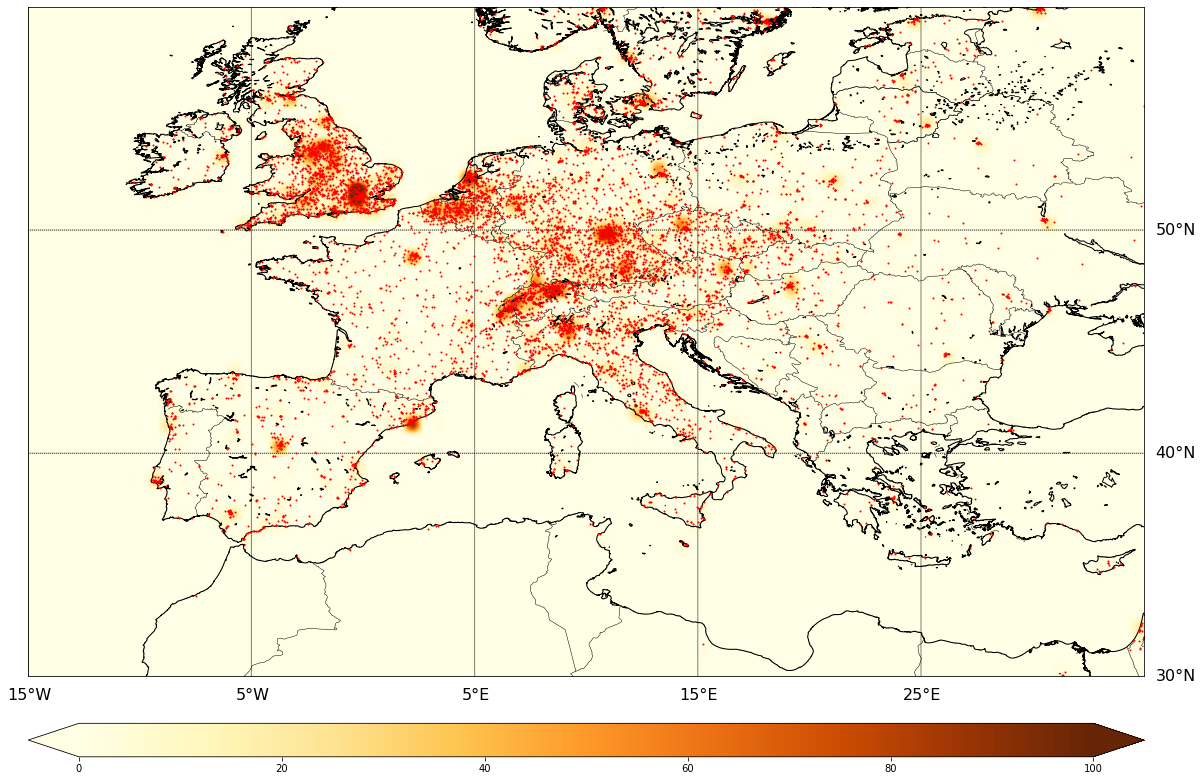

In [26]:
fig=plt.figure(figsize=(20,15))
map.drawcoastlines(linewidth=1)
map.drawstates()
map.drawcountries()
parallels = np.arange(min_lat,max_lat,10)
map.drawparallels(parallels,labels=[False,True,True,False],fontsize=16)
meridians = np.arange(min_lon,max_lon,10)
map.drawmeridians(meridians,labels=[True,False,False,True],fontsize=16)

a = map.imshow(density.T, interpolation='spline36', alpha=1, cmap='YlOrBr',vmin=0,vmax=100)
cbar = map.colorbar(a,'bottom', pad='7%',extend='both')

for lons, lats in zip(Lon, Lat):
    x, y = map.projtran(lons,lats)
    map.plot(x,y,'ro',markersize=1)

## Switzerland

In [27]:
min_lon = 5 #-15 Europe, -5 Eq test
max_lon = 11 #35 Europe, 45 Eq test
min_lat = 45 #30 Europe, -10 Eq test
max_lat = 48 #60 Europe, 10 Eq test
res = 0.1 #resolution of X degrees

nx,ny = int((max_lon-min_lon)/res),int((max_lat-min_lat)/res)
lon_bins = np.linspace(min_lon,max_lon,nx+1)
lat_bins = np.linspace(min_lat,max_lat,ny+1)

In [28]:
density, _, _ = np.histogram2d(Lon,Lat,[lon_bins,lat_bins])

In [29]:
map = Basemap(projection='cyl',llcrnrlon=min_lon,llcrnrlat= min_lat, urcrnrlon=max_lon,urcrnrlat=max_lat,resolution='f')

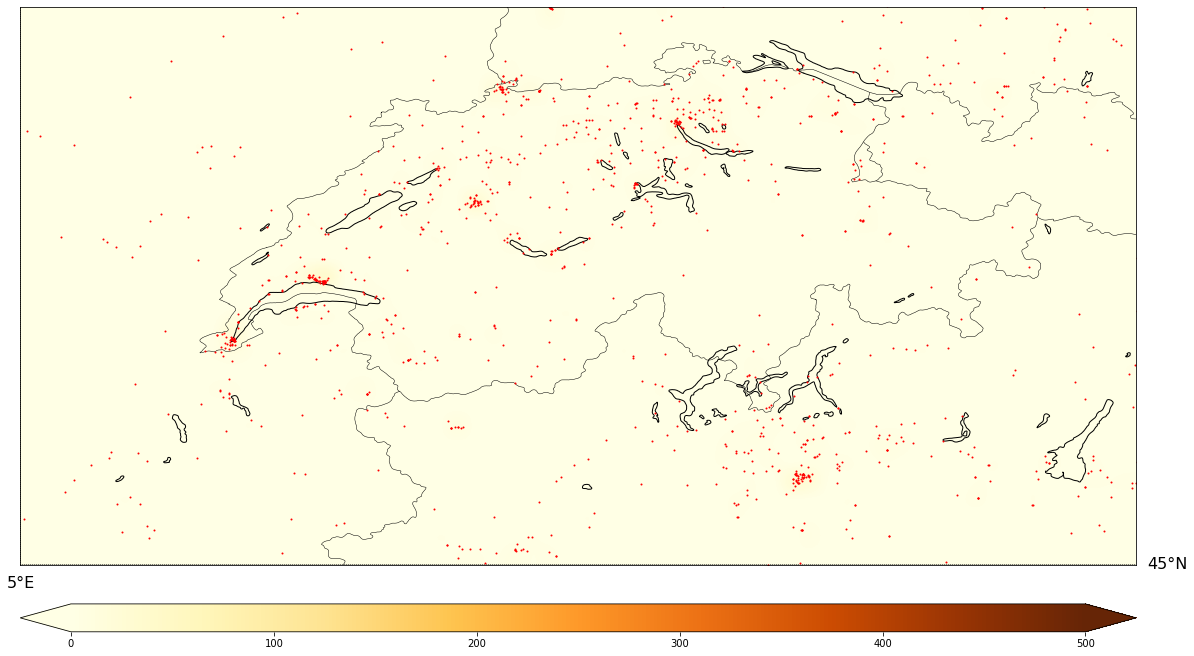

In [30]:
fig=plt.figure(figsize=(20,15))
map.drawcoastlines(linewidth=1)
map.drawstates()
map.drawcountries()
parallels = np.arange(min_lat,max_lat,10)
map.drawparallels(parallels,labels=[False,True,True,False],fontsize=16)
meridians = np.arange(min_lon,max_lon,10)
map.drawmeridians(meridians,labels=[True,False,False,True],fontsize=16)

a = map.imshow(density.T, interpolation='spline36', alpha=1, cmap='YlOrBr',vmin=0,vmax=500)
cbar = map.colorbar(a,'bottom', pad='7%',extend='both')

for lons, lats in zip(Lon, Lat):
    x, y = map.projtran(lons,lats)
    map.plot(x,y,'ro',markersize=1)

In [31]:
min_lon = 2 #-15 Europe, -5 Eq test
max_lon = 7 #35 Europe, 45 Eq test
min_lat = 49 #30 Europe, -10 Eq test
max_lat = 54 #60 Europe, 10 Eq test
res = 0.1 #resolution of X degrees

nx,ny = int((max_lon-min_lon)/res),int((max_lat-min_lat)/res)
lon_bins = np.linspace(min_lon,max_lon,nx+1)
lat_bins = np.linspace(min_lat,max_lat,ny+1)

In [32]:
density, _, _ = np.histogram2d(Lon,Lat,[lon_bins,lat_bins])

In [33]:
map = Basemap(projection='cyl',llcrnrlon=min_lon,llcrnrlat= min_lat, urcrnrlon=max_lon,urcrnrlat=max_lat,resolution='f')

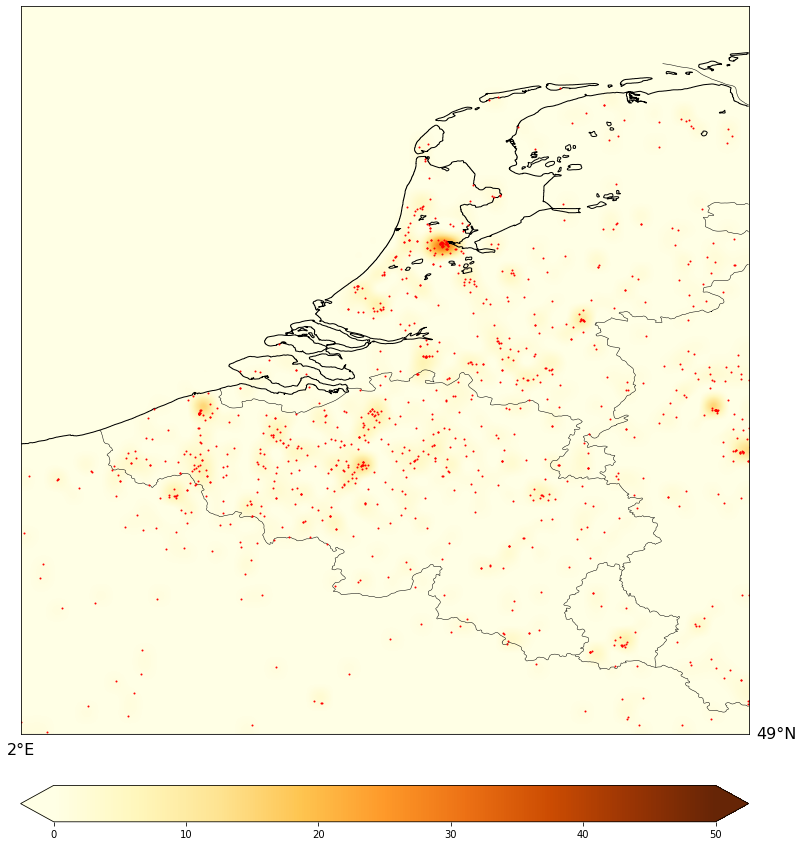

In [34]:
fig=plt.figure(figsize=(20,15))
map.drawcoastlines(linewidth=1)
map.drawstates()
map.drawcountries()
parallels = np.arange(min_lat,max_lat,10)
map.drawparallels(parallels,labels=[False,True,True,False],fontsize=16)
meridians = np.arange(min_lon,max_lon,10)
map.drawmeridians(meridians,labels=[True,False,False,True],fontsize=16)

a = map.imshow(density.T, interpolation='spline36', alpha=1, cmap='YlOrBr',vmin=0,vmax=50)
cbar = map.colorbar(a,'bottom', pad='7%',extend='both')

for lons, lats in zip(Lon, Lat):
    x, y = map.projtran(lons,lats)
    map.plot(x,y,'ro',markersize=1)

In [3]:
df_latlng = pd.read_csv("./Data/breweries_api_Baptiste_version.csv")

In [4]:
print(df_latlng.shape)
df_latlng = df_latlng.dropna()
print(df_latlng.shape)

(24185, 8)
(21630, 8)


Add the geometry and use geopandas cities and world dataframes

In [5]:
gdf_bre_world = gpd.GeoDataFrame(
   df_latlng, geometry=gpd.points_from_xy(df_latlng.longitude, df_latlng.latitude))

gdf_bre_world = gdf_bre_world.set_crs(epsg=4326)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

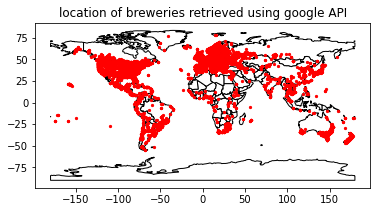

In [6]:
fig, ax = plt.subplots()

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')


gdf_bre_world.plot(ax=ax, marker='o', color='red', markersize=5)

plt.title("location of breweries retrieved using google API")
plt.show();

In [9]:
# Extract a shapefile with switzerland boundaries of cantons
fname = "./Data/Cities.shp"

df = gpd.read_file(fname)
df = df.set_crs(epsg=4326)



# PIP test with 'within'
gdf_bre_world[gdf_bre_world['geometry'].within(df['geometry'])]   # True


num_breweries_per_city = df.merge(gpd.sjoin(gdf_bre_world, df).groupby("index_right").size().rename("points"),
                                  left_index=True, right_index=True, how="left")
num_breweries_per_city.head(1)
num_breweries_per_city = gdf_bre_world.merge(gpd.sjoin(gdf_bre_world, df).groupby("index_right").size().rename("points"),
                                             left_index=True, right_index=True, how="left")
inp, res = df.sindex.query_bulk(gdf_bre_world.geometry, predicate='intersects')
gdf_bre_world['intersects'] = np.isin(np.arange(0, len(gdf_bre_world)), inp)
print((gdf_bre_world['intersects']==True).sum())
print((gdf_bre_world['intersects']==False).sum())

df_with_city_pop=gpd.sjoin(gdf_bre_world, df)
df_with_city_pop.drop(df_with_city_pop.columns[[0,1,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]], axis=1, inplace=True)
df_with_city_pop



C:\Users\revei\anaconda3\lib\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\Users\revei\anaconda3\lib\site-packages\geopandas\geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


10587
11043


,brewery_id,location,name,nbr_beers,latitude,longitude,geometry,intersects,index_right,name_conve,max_pop_al
0,3198,Gabon,Sobraga,3,0.303409,9.501448,POINT (9.50145 0.30341),True,2956,Libreville,483355.0
2,22304,Northern Ireland,Barrahooley Craft Brewery,4,54.520266,-6.025840,POINT (-6.02584 54.52027),True,579,Belfast,450406.0
4,24297,Northern Ireland,Brewbot Belfast,3,54.575613,-5.917369,POINT (-5.91737 54.57561),True,579,Belfast,450406.0
5,27006,Northern Ireland,Bullhouse Brewing Company,6,54.574118,-5.961318,POINT (-5.96132 54.57412),True,579,Belfast,450406.0
13,19638,Northern Ireland,Hercules,6,54.599274,-5.932942,POINT (-5.93294 54.59927),True,579,Belfast,450406.0
...,...,...,...,...,...,...,...,...,...,...,...
24131,28962,Thailand,Outlaw Brewing,18,17.486602,101.728462,POINT (101.72846 17.48660),True,3018,Loei,24543.0
24141,29242,Thailand,Six Post Meridiem Brewing,3,7.886356,98.392138,POINT (98.39214 7.88636),True,4114,Phuket,141618.0
24159,31889,Thailand,Underdog,1,19.907785,99.824139,POINT (99.82414 19.90778),True,1103,Chiang Rai,117127.0
24182,9355,Albania,Hotel Martini,1,40.457752,19.485546,POINT (19.48555 40.45775),True,5691,Vlore,89471.0


In [8]:
world=world.set_crs(epsg=4326, allow_override=True)
gdf_bre_bis = gdf_bre.sjoin(world, how="inner", predicate='within')
print(gdf_bre_bis.crs)
print(world.crs)
gdf_bre_world = gdf_bre_world.set_crs(epsg=4326)
gdf_with_breweries =  gdf_bre_world.sjoin(world, how="inner", predicate='intersects')
boolean = gdf_with_breweries['location'] == gdf_with_breweries['name_right']
gdf_with_breweries = gdf_with_breweries[~boolean]
gdf_with_breweries

NameError: name 'gdf_bre' is not defined